# Applied Data Science Capstone Project
Using historical data to analyse and estimate road accident severity.

In [149]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import matplotlib.ticker as ticker
from sklearn import preprocessing
import seaborn as sns
%matplotlib inline

In [150]:
filename = 'Data-Collisions.csv'
collisions_loaded = pd.read_csv(filename)
collisions_loaded.head()

C:\Anaconda\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N


### Copy loaded data for convenience

In [151]:
collisions_df = collisions_loaded.copy()
collisions_df.shape

(194673, 38)

## Clean Data

In [152]:
print('Loaded data dimensions (shape)', collisions_df.shape)
collisions_df.dtypes

Loaded data dimensions (shape) (194673, 38)


SEVERITYCODE        int64
X                 float64
Y                 float64
OBJECTID            int64
INCKEY              int64
COLDETKEY           int64
REPORTNO           object
STATUS             object
ADDRTYPE           object
INTKEY            float64
LOCATION           object
EXCEPTRSNCODE      object
EXCEPTRSNDESC      object
SEVERITYCODE.1      int64
SEVERITYDESC       object
COLLISIONTYPE      object
PERSONCOUNT         int64
PEDCOUNT            int64
PEDCYLCOUNT         int64
VEHCOUNT            int64
INCDATE            object
INCDTTM            object
JUNCTIONTYPE       object
SDOT_COLCODE        int64
SDOT_COLDESC       object
INATTENTIONIND     object
UNDERINFL          object
WEATHER            object
ROADCOND           object
LIGHTCOND          object
PEDROWNOTGRNT      object
SDOTCOLNUM        float64
SPEEDING           object
ST_COLCODE         object
ST_COLDESC         object
SEGLANEKEY          int64
CROSSWALKKEY        int64
HITPARKEDCAR       object
dtype: objec

### Item: SEVERITYCODE
This code corresponds to the severity of the collision. Only two codes are represented in the data ***(1=property damage and 2=injury)***. This code can be used as the target labels for the purpose of machine learning (ML). The redundundant SEVERITYCODE.1 should be dropped.
<p/>

### Item: X, Y
These are coordinates, ***where X=longitude (magnitudes<180) and Y=latitude (magnitudes<90)*** - these can be renamed used instead of the **LOCATION**, which is a description of the general location of the collision. So LOCATION should be dropped.
<p/>

### Initial List of Reduncant Items: (***based on insights drawn from the metadata document***)
OBJECTID, INCKEY, COLDETKEY, REPORTNO, INTKEY, EXCEPTRSNCODE, EXCEPTRSNDESC, SEVERITYDESC (***deferred***), INCDATE (***prefer INCDTTM***), SDOT_COLDESC, ST_COLDESC

In [153]:
colns_to_drop = ['SEVERITYCODE.1', 'LOCATION', 'OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO', 'INTKEY', 'EXCEPTRSNCODE',\
                 'EXCEPTRSNDESC', 'SEVERITYDESC', 'INCDATE', 'SDOT_COLDESC', 'ST_COLDESC']
collisions_df.drop(columns=colns_to_drop, inplace=True)

In [154]:
collisions_df.rename(columns={'X': 'longitude', 'Y': 'latitude'}, inplace=True)
collisions_df

,SEVERITYCODE,longitude,latitude,STATUS,ADDRTYPE,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,...,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,Matched,Intersection,Angles,2,0,0,2,...,Overcast,Wet,Daylight,NaN,NaN,NaN,10,0,0,N
1,1,-122.347294,47.647172,Matched,Block,Sideswipe,2,0,0,2,...,Raining,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,0,0,N
2,1,-122.334540,47.607871,Matched,Block,Parked Car,4,0,0,3,...,Overcast,Dry,Daylight,NaN,4323031.0,NaN,32,0,0,N
3,1,-122.334803,47.604803,Matched,Block,Other,3,0,0,3,...,Clear,Dry,Daylight,NaN,NaN,NaN,23,0,0,N
4,2,-122.306426,47.545739,Matched,Intersection,Angles,2,0,0,2,...,Raining,Wet,Daylight,NaN,4028032.0,NaN,10,0,0,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194668,2,-122.290826,47.565408,Matched,Block,Head On,3,0,0,2,...,Clear,Dry,Daylight,NaN,NaN,NaN,24,0,0,N
194669,1,-122.344526,47.690924,Matched,Block,Rear Ended,2,0,0,2,...,Raining,Wet,Daylight,NaN,NaN,NaN,13,0,0,N
194670,2,-122.306689,47.683047,Matched,Intersection,Left Turn,3,0,0,2,...,Clear,Dry,Daylight,NaN,NaN,NaN,28,0,0,N
194671,2,-122.355317,47.678734,Matched,Intersection,Cycles,2,0,1,1,...,Clear,Dry,Dusk,NaN,NaN,NaN,5,4308,0,N


### Revisit the column data types

In [155]:
collisions_df.dtypes

SEVERITYCODE        int64
longitude         float64
latitude          float64
STATUS             object
ADDRTYPE           object
COLLISIONTYPE      object
PERSONCOUNT         int64
PEDCOUNT            int64
PEDCYLCOUNT         int64
VEHCOUNT            int64
INCDTTM            object
JUNCTIONTYPE       object
SDOT_COLCODE        int64
INATTENTIONIND     object
UNDERINFL          object
WEATHER            object
ROADCOND           object
LIGHTCOND          object
PEDROWNOTGRNT      object
SDOTCOLNUM        float64
SPEEDING           object
ST_COLCODE         object
SEGLANEKEY          int64
CROSSWALKKEY        int64
HITPARKEDCAR       object
dtype: object

<hr color= "red"/> 

### Data Visualization and Pre-processing
Based on the target labels, let’s see how many of each class are in the data set (is it balanced or unbalanced)

In [156]:
collisions_df['SEVERITYCODE'].value_counts()

1    136485
2     58188
Name: SEVERITYCODE, dtype: int64

Summary:<br/>
    136485 collisions are property damage (1) and 58188 (injury)

Plot some columns to get a better understanding of the data set:

### Convert to date time object 

In [157]:
collisions_df['INCDTTM'] = pd.to_datetime(collisions_df['INCDTTM'])
collisions_df['INCDTTM'].head()

0   2013-03-27 14:54:00
1   2006-12-20 18:55:00
2   2004-11-18 10:20:00
3   2013-03-29 09:26:00
4   2004-01-28 08:04:00
Name: INCDTTM, dtype: datetime64[ns]

### Lets look at the hour of the day that collisions occur

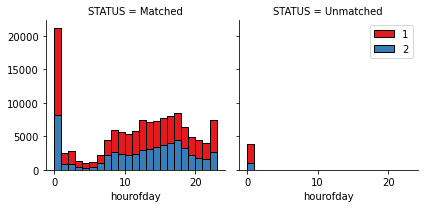

In [158]:
collisions_df['hourofday'] = collisions_df['INCDTTM'].dt.hour
bins = np.linspace(collisions_df.hourofday.min(), collisions_df.hourofday.max(), 24)
g = sns.FacetGrid(collisions_df, col="STATUS", hue="SEVERITYCODE", palette="Set1", col_wrap=2)
g.map(plt.hist, 'hourofday', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

It appears that there is an unusual volume of collisions in the first hour of the day. So we can use feature binarization to set a threshold value less than hour 12 or morning hours 

In [159]:
morning_threshold = 12
collisions_df['morning'] = collisions_df['hourofday'].apply(lambda x: 1 if (x>morning_threshold)  else 0)
collisions_df[['INCDTTM', 'morning']].head()

,INCDTTM,morning
0,2013-03-27 14:54:00,1
1,2006-12-20 18:55:00,1
2,2004-11-18 10:20:00,0
3,2013-03-29 09:26:00,0
4,2004-01-28 08:04:00,0


<hr color= "red"/> 

## Convert Categorical features to numerical values

Lets look at collision status:
*Matched possibly refers to matched pairs or collisions involving two vehicles, see this study in the <a href="https://academic.oup.com/aje/article/167/5/546/211795">American Journal of Epidemiology</a>.

In [160]:
collisions_df.groupby(['STATUS'])['SEVERITYCODE'].value_counts(normalize=True)

STATUS     SEVERITYCODE
Matched    1               0.698824
           2               0.301176
Unmatched  1               0.789441
           2               0.210559
Name: SEVERITYCODE, dtype: float64

30% of matched collisions result in injury compared to 21% of unmatched collisions - not a huge difference but significant

Lets convert matched to 0 and unmatched to 1:

In [161]:
collisions_df['STATUS'].replace(to_replace=['Matched','Unmatched'], value=[0, 1],inplace=True)

Lets look at inattention: *(reasonable default seems to be 'N')*

In [162]:
# first replace all missing data with 'N' - seems a reasonable default
collisions_df['INATTENTIONIND'].fillna('N', inplace=True)
collisions_df['INATTENTIONIND'].replace(to_replace=['N','Y'], value=[0, 1],inplace=True)

In [163]:
collisions_df.groupby(['INATTENTIONIND'])['SEVERITYCODE'].value_counts(normalize=True)

INATTENTIONIND  SEVERITYCODE
0               1               0.710126
                2               0.289874
1               1               0.651166
                2               0.348834
Name: SEVERITYCODE, dtype: float64

In 35% of collisions inattention = Y result in injury, compared to 29% where inattention = N.<br/>

Lets look at under the influence: *(0=N, 1=Y)*

In [164]:
# first replace all missing data with 'N' or 0 - seems a reasonable default
collisions_df['UNDERINFL'].fillna('N', inplace=True)
collisions_df['UNDERINFL'].replace(to_replace=['0', '1','N','Y'], value=[0, 1, 0, 1],inplace=True)
collisions_df['UNDERINFL'] = collisions_df['UNDERINFL'].astype(int)

In [165]:
collisions_df.groupby(['UNDERINFL'])['SEVERITYCODE'].value_counts(normalize=True)

UNDERINFL  SEVERITYCODE
0          1               0.705603
           2               0.294397
1          1               0.609473
           2               0.390527
Name: SEVERITYCODE, dtype: float64

In 39% of collisions with driver under the influence resulted in injury, compared to 29% with driver not under the influence.<br/>

Lets look at speeding: *(0=N, 1=Y)*

In [166]:
# first replace all missing data with 'N' or 0 - seems a reasonable default
collisions_df['SPEEDING'].fillna('N', inplace=True)
collisions_df['SPEEDING'].replace(to_replace=['N','Y'], value=[0, 1],inplace=True)
collisions_df['SPEEDING'] = collisions_df['SPEEDING'].astype(int)

In [167]:
collisions_df.groupby(['SPEEDING'])['SEVERITYCODE'].value_counts(normalize=True)

SPEEDING  SEVERITYCODE
0         1               0.705099
          2               0.294901
1         1               0.621665
          2               0.378335
Name: SEVERITYCODE, dtype: float64

In 38% of collisions with driver speeding resulted in injury, compared to 29% with driver not speeding.<br/>

<hr color= "red"/> 

At this point, check the status of the dataframe:

In [168]:
collisions_df.head()

,SEVERITYCODE,longitude,latitude,STATUS,ADDRTYPE,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,...,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR,hourofday,morning
0,2,-122.323148,47.703140,0,Intersection,Angles,2,0,0,2,...,Daylight,NaN,NaN,0,10,0,0,N,14,1
1,1,-122.347294,47.647172,0,Block,Sideswipe,2,0,0,2,...,Dark - Street Lights On,NaN,6354039.0,0,11,0,0,N,18,1
2,1,-122.334540,47.607871,0,Block,Parked Car,4,0,0,3,...,Daylight,NaN,4323031.0,0,32,0,0,N,10,0
3,1,-122.334803,47.604803,0,Block,Other,3,0,0,3,...,Daylight,NaN,NaN,0,23,0,0,N,9,0
4,2,-122.306426,47.545739,0,Intersection,Angles,2,0,0,2,...,Daylight,NaN,4028032.0,0,10,0,0,N,8,0


<hr color= "red"/> 

## One Hot Encoding  
#### Lets start with collision type

In [169]:
# make sure all NaN are converted to 'Other'
collisions_df['COLLISIONTYPE'].fillna('Other', inplace=True)
np.array(set(collisions_df['COLLISIONTYPE'].values))

array({'Right Turn', 'Pedestrian', 'Parked Car', 'Left Turn', 'Cycles', 'Sideswipe', 'Angles', 'Head On', 'Other', 'Rear Ended'},
      dtype=object)

In [198]:
collisions_df.groupby(['COLLISIONTYPE'])['SEVERITYCODE'].value_counts(normalize=False)
#collisions_df.groupby(['COLLISIONTYPE'])['SEVERITYCODE'].value_counts(normalize=True)

COLLISIONTYPE  SEVERITYCODE
Angles         1               21050
               2               13624
Cycles         2                4744
               1                 671
Head On        1                1152
               2                 872
Left Turn      1                8292
               2                5411
Other          1               21454
               2                7153
Parked Car     1               45325
               2                2662
Pedestrian     2                5936
               1                 672
Rear Ended     1               19419
               2               14671
Right Turn     1                2347
               2                 609
Sideswipe      1               16103
               2                2506
Name: SEVERITYCODE, dtype: int64

Lets look at the weather:

In [171]:
# make sure all NaN are converted to 'Other'
collisions_df['WEATHER'].fillna('Other', inplace=True)
np.array(set(collisions_df['WEATHER'].values))

array({'Severe Crosswind', 'Partly Cloudy', 'Unknown', 'Clear', 'Raining', 'Overcast', 'Sleet/Hail/Freezing Rain', 'Blowing Sand/Dirt', 'Snowing', 'Other', 'Fog/Smog/Smoke'},
      dtype=object)

In [172]:
collisions_df.groupby(['WEATHER'])['SEVERITYCODE'].value_counts(normalize=True)

WEATHER                   SEVERITYCODE
Blowing Sand/Dirt         1               0.732143
                          2               0.267857
Clear                     1               0.677509
                          2               0.322491
Fog/Smog/Smoke            1               0.671353
                          2               0.328647
Other                     1               0.797057
                          2               0.202943
Overcast                  1               0.684456
                          2               0.315544
Partly Cloudy             2               0.600000
                          1               0.400000
Raining                   1               0.662815
                          2               0.337185
Severe Crosswind          1               0.720000
                          2               0.280000
Sleet/Hail/Freezing Rain  1               0.752212
                          2               0.247788
Snowing                   1               0

Lets look at road conditions:

In [173]:
# make sure all NaN are converted to 'Other'
collisions_df['ROADCOND'].fillna('Other', inplace=True)
np.array(set(collisions_df['ROADCOND'].values))

array({'Wet', 'Other', 'Sand/Mud/Dirt', 'Unknown', 'Oil', 'Snow/Slush', 'Ice', 'Dry', 'Standing Water'},
      dtype=object)

In [174]:
collisions_df.groupby(['ROADCOND'])['SEVERITYCODE'].value_counts(normalize=True)

ROADCOND        SEVERITYCODE
Dry             1               0.678227
                2               0.321773
Ice             1               0.774194
                2               0.225806
Oil             1               0.625000
                2               0.375000
Other           1               0.785575
                2               0.214425
Sand/Mud/Dirt   1               0.693333
                2               0.306667
Snow/Slush      1               0.833665
                2               0.166335
Standing Water  1               0.739130
                2               0.260870
Unknown         1               0.950325
                2               0.049675
Wet             1               0.668134
                2               0.331866
Name: SEVERITYCODE, dtype: float64

Lets look at light conditions:

In [175]:
# make sure all NaN are converted to 'Other'
collisions_df['LIGHTCOND'].fillna('Other', inplace=True)
np.array(set(collisions_df['LIGHTCOND'].values))

array({'Dawn', 'Dark - Street Lights Off', 'Dark - No Street Lights', 'Daylight', 'Dark - Unknown Lighting', 'Unknown', 'Other', 'Dark - Street Lights On', 'Dusk'},
      dtype=object)

In [176]:
collisions_df.groupby(['LIGHTCOND'])['SEVERITYCODE'].value_counts(normalize=True)

LIGHTCOND                 SEVERITYCODE
Dark - No Street Lights   1               0.782694
                          2               0.217306
Dark - Street Lights Off  1               0.736447
                          2               0.263553
Dark - Street Lights On   1               0.701589
                          2               0.298411
Dark - Unknown Lighting   1               0.636364
                          2               0.363636
Dawn                      1               0.670663
                          2               0.329337
Daylight                  1               0.668116
                          2               0.331884
Dusk                      1               0.670620
                          2               0.329380
Other                     1               0.788714
                          2               0.211286
Unknown                   1               0.955095
                          2               0.044905
Name: SEVERITYCODE, dtype: float64

<hr color= "red"/> 

# Combining Latitude/Longitude
Combining latitude/longitude position into single feature using the <a href="https://datascience.stackexchange.com/questions/49553/combining-latitude-longitude-position-into-single-feature">Haversine formula</a>

In [183]:
from math import radians, cos, sin, asin, sqrt

def location(lat, lng, degrees=True):
    """
    'Single-point' Haversine: Calculates the great circle distance
    between a point on Earth and the (0, 0) lat-long coordinate
    """
    r = 6371 # Earth's radius (km). Have r = 3956 if you want miles

    # Convert decimal degrees to radians
    if degrees:
        lat, lng = map(radians, [lat, lng])

    # 'Single-point' Haversine formula
    a = sin(lat/2)**2 + cos(lat) * sin(lng/2)**2
    d = 2 * r * asin(sqrt(a)) 

    return d

Use the location function defined to calculate a single location for each pair of latitude/longitude:

In [184]:
collisions_df['location'] = [location(x, y) for x, y in zip(collisions_df.latitude, collisions_df.longitude)]
collisions_df['location'].head()

0    12352.644223
1    12356.919651
2    12357.905534
3    12358.067920
4    12358.918252
Name: location, dtype: float64

Lets look at the locations that collisions occur:

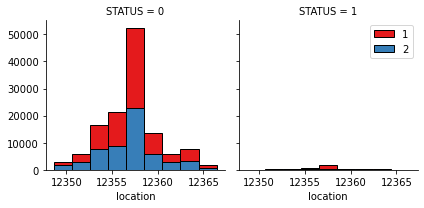

In [187]:
bins = np.linspace(collisions_df.location.min(), collisions_df.location.max(), 10)
g = sns.FacetGrid(collisions_df, col="STATUS", hue="SEVERITYCODE", palette="Set1", col_wrap=2)
g.map(plt.hist, 'location', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

**Summary:** It seems that most of the collisions occure within approximately one standard deviation from a mean point (hot spot).<br/>
We can use feature binarization to set a threshold value about one standard deviation from the hot spot (mean).

In [192]:
hot_spot = collisions_df.location.mean()
loc_std = collisions_df.location.std()
print('The hot spot is estimated at location [mean =', hot_spot, ',std =', loc_std,']')

The hot spot is estimated at location [mean = 12357.08123630904 ,std = 3.0681291833829416 ]


In [193]:
# binarize location --> point is either within the standard deviation window or not
thres_mult = 1 # i.e. thres_mult * standard deviations from the hot spot
lower_bound = hot_spot - thres_mult*loc_std
upper_bound = hot_spot + thres_mult*loc_std
collisions_df['location'] = collisions_df['location'].apply(lambda x: 1 if (x>lower_bound and x<upper_bound) else 0)
collisions_df['location'].head()

0    0
1    1
2    1
3    1
4    1
Name: location, dtype: int64

<hr color= "red"/> 

### Summarize Collisions Data Set

In [194]:
collisions_df.dtypes

SEVERITYCODE               int64
longitude                float64
latitude                 float64
STATUS                     int64
ADDRTYPE                  object
COLLISIONTYPE             object
PERSONCOUNT                int64
PEDCOUNT                   int64
PEDCYLCOUNT                int64
VEHCOUNT                   int64
INCDTTM           datetime64[ns]
JUNCTIONTYPE              object
SDOT_COLCODE               int64
INATTENTIONIND             int64
UNDERINFL                  int32
WEATHER                   object
ROADCOND                  object
LIGHTCOND                 object
PEDROWNOTGRNT             object
SDOTCOLNUM               float64
SPEEDING                   int32
ST_COLCODE                object
SEGLANEKEY                 int64
CROSSWALKKEY               int64
HITPARKEDCAR              object
hourofday                  int64
morning                    int64
location                   int64
dtype: object

## Create features set from the prepared data set

In [195]:
Features = collisions_df[['location','STATUS','COLLISIONTYPE','PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', \
                          'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND', 'SPEEDING', 'morning']]
Features.head()

,location,STATUS,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,SPEEDING,morning
0,0,0,Angles,2,0,0,2,0,0,Overcast,Wet,Daylight,0,1
1,1,0,Sideswipe,2,0,0,2,0,0,Raining,Wet,Dark - Street Lights On,0,1
2,1,0,Parked Car,4,0,0,3,0,0,Overcast,Dry,Daylight,0,0
3,1,0,Other,3,0,0,3,0,0,Clear,Dry,Daylight,0,0
4,1,0,Angles,2,0,0,2,0,0,Raining,Wet,Daylight,0,0


#### We use the one hot encoding technique to conver categorical varables, such as collision type, to binary variables and append them to the features Data Frame 

In [196]:
Features = pd.concat([Features, pd.get_dummies(collisions_df[['COLLISIONTYPE', 'WEATHER', 'ROADCOND', 'LIGHTCOND']])], axis=1)
Features.drop(['COLLISIONTYPE', 'WEATHER', 'ROADCOND', 'LIGHTCOND'], axis = 1, inplace=True)
Features.head()

,location,STATUS,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INATTENTIONIND,UNDERINFL,SPEEDING,morning,...,ROADCOND_Wet,LIGHTCOND_Dark - No Street Lights,LIGHTCOND_Dark - Street Lights Off,LIGHTCOND_Dark - Street Lights On,LIGHTCOND_Dark - Unknown Lighting,LIGHTCOND_Dawn,LIGHTCOND_Daylight,LIGHTCOND_Dusk,LIGHTCOND_Other,LIGHTCOND_Unknown
0,0,0,2,0,0,2,0,0,0,1,...,1,0,0,0,0,0,1,0,0,0
1,1,0,2,0,0,2,0,0,0,1,...,1,0,0,1,0,0,0,0,0,0
2,1,0,4,0,0,3,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1,0,3,0,0,3,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,1,0,2,0,0,2,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0


In [199]:
Features.columns

Index(['location', 'STATUS', 'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT',
       'VEHCOUNT', 'INATTENTIONIND', 'UNDERINFL', 'SPEEDING', 'morning',
       'COLLISIONTYPE_Angles', 'COLLISIONTYPE_Cycles', 'COLLISIONTYPE_Head On',
       'COLLISIONTYPE_Left Turn', 'COLLISIONTYPE_Other',
       'COLLISIONTYPE_Parked Car', 'COLLISIONTYPE_Pedestrian',
       'COLLISIONTYPE_Rear Ended', 'COLLISIONTYPE_Right Turn',
       'COLLISIONTYPE_Sideswipe', 'WEATHER_Blowing Sand/Dirt', 'WEATHER_Clear',
       'WEATHER_Fog/Smog/Smoke', 'WEATHER_Other', 'WEATHER_Overcast',
       'WEATHER_Partly Cloudy', 'WEATHER_Raining', 'WEATHER_Severe Crosswind',
       'WEATHER_Sleet/Hail/Freezing Rain', 'WEATHER_Snowing',
       'WEATHER_Unknown', 'ROADCOND_Dry', 'ROADCOND_Ice', 'ROADCOND_Oil',
       'ROADCOND_Other', 'ROADCOND_Sand/Mud/Dirt', 'ROADCOND_Snow/Slush',
       'ROADCOND_Standing Water', 'ROADCOND_Unknown', 'ROADCOND_Wet',
       'LIGHTCOND_Dark - No Street Lights',
       'LIGHTCOND_Dark - Street Lights O

In [181]:
Features.shape

(194673, 50)

<hr color= "red"/> 

### Classification Features selection

Now, we define the classification feature sets, X:

In [202]:
# remove all the unknown or other conditions as they add very little interpretational or meaningful value
# further refinement based on the earlier analysis done above
short_listed = ['location', 'STATUS', 'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INATTENTIONIND', \
                'UNDERINFL', 'SPEEDING', 'morning', 'COLLISIONTYPE_Angles', 'COLLISIONTYPE_Cycles', 'COLLISIONTYPE_Head On', \
                'COLLISIONTYPE_Left Turn', 'COLLISIONTYPE_Parked Car', 'COLLISIONTYPE_Pedestrian', 'COLLISIONTYPE_Rear Ended', \
                'COLLISIONTYPE_Right Turn', 'COLLISIONTYPE_Sideswipe', 'WEATHER_Blowing Sand/Dirt', 'WEATHER_Clear', \
                'WEATHER_Fog/Smog/Smoke', 'WEATHER_Overcast', 'WEATHER_Partly Cloudy', 'WEATHER_Raining', \
                'WEATHER_Severe Crosswind', 'WEATHER_Sleet/Hail/Freezing Rain', 'WEATHER_Snowing', \
                'ROADCOND_Dry', 'ROADCOND_Ice', 'ROADCOND_Oil', 'ROADCOND_Sand/Mud/Dirt', 'ROADCOND_Snow/Slush', \
                'ROADCOND_Standing Water', 'ROADCOND_Wet', 'LIGHTCOND_Dark - No Street Lights', \
                'LIGHTCOND_Dark - Street Lights Off', 'LIGHTCOND_Dark - Street Lights On', 'LIGHTCOND_Dawn', \
                'LIGHTCOND_Daylight', 'LIGHTCOND_Dusk']
X = Features[short_listed]
X[0:5]

,location,STATUS,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INATTENTIONIND,UNDERINFL,SPEEDING,morning,...,ROADCOND_Sand/Mud/Dirt,ROADCOND_Snow/Slush,ROADCOND_Standing Water,ROADCOND_Wet,LIGHTCOND_Dark - No Street Lights,LIGHTCOND_Dark - Street Lights Off,LIGHTCOND_Dark - Street Lights On,LIGHTCOND_Dawn,LIGHTCOND_Daylight,LIGHTCOND_Dusk
0,0,0,2,0,0,2,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
1,1,0,2,0,0,2,0,0,0,1,...,0,0,0,1,0,0,1,0,0,0
2,1,0,4,0,0,3,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1,0,3,0,0,3,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1,0,2,0,0,2,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0


**Observation:** The initial subset has 41 features. This is a very high number of features and it is expected that further rationalization will have to be made after the first run to reduce the number of features.

Lets prepare the target labels:

In [203]:
y = collisions_df['SEVERITYCODE'].values
y[0:5]

array([2, 1, 1, 1, 2], dtype=int64)

## Data Normalization

In [204]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[-1.50437693, -0.16046824, -0.33020207, -0.18743029, -0.16958841,
         0.12553783, -0.42518348, -0.2217116 , -0.22440165,  1.01068516,
         2.14811072, -0.16915004, -0.10249953, -0.27517219, -0.57196238,
        -0.18744809, -0.46074827, -0.12417149, -0.32510694, -0.01696304,
        -1.15340914, -0.05414257,  2.45445634, -0.00506801, -0.45298634,
        -0.011333  , -0.02409974, -0.06841713, -1.33213439, -0.07905204,
        -0.01813462, -0.01963186, -0.07200071, -0.02431221,  1.76085874,
        -0.08920831, -0.07872239, -0.576075  , -0.1141037 ,  0.82233559,
        -0.17682024],
       [ 0.66472702, -0.16046824, -0.33020207, -0.18743029, -0.16958841,
         0.12553783, -0.42518348, -0.2217116 , -0.22440165,  1.01068516,
        -0.46552535, -0.16915004, -0.10249953, -0.27517219, -0.57196238,
        -0.18744809, -0.46074827, -0.12417149,  3.07591099, -0.01696304,
        -1.15340914, -0.05414257, -0.4074222 , -0.00506801,  2.2075721 ,
        -0.011333  , -0.02409

# Classification

A training set is used to build a accurate model, based on a set of classifiers. A test set is used to evaluate the accuracy of classifiers. Thereafter, the best classifier model is selected.

The following candidate classifier algorithms are evaluated:
- K Nearest Neighbor(KNN) *(typically, simple and expected to do a good jobs)*
- Decision Tree
- Support Vector Machine
- Logistic Regression

### Prepare the Training and Test Sets

In [206]:
from sklearn.model_selection import train_test_split
test_prop = 0.25 # the data set is relatively large, so a higher proportion can be reserved for testing
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=test_prop, random_state=0)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (146004, 41) (146004,)
Test set: (48669, 41) (48669,)


# K Nearest Neighbor(KNN)